In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as cons
import h5py
import os
from matplotlib.colors import LightSource, LogNorm
from scipy.spatial import KDTree

from torreylabtools import helpers
# from torreylabtools.visualization import contour_makepic as makepic
# from torreylabtools.util import calc_hsml as calc_hsml
# from torreylabtools.util import naming as namingx
# from torreylabtools import kdtree_smoothing as kda
from LtU_get_property import get_particle_property_LTU
import arepo_package as arepo_package
from density_profile import fibonacci_sphere, calc_density

In [2]:
os.environ["MANPATH"] = "/standard/torrey-group/Share/texlive/2018/texmf-dist/doc/man:" + os.environ.get("MANPATH", "")
os.environ["INFOPATH"] = "/standard/torrey-group/Share/texlive/2018/texmf-dist/doc/info:" + os.environ.get("INFOPATH", "")
os.environ["PATH"] = "/standard/torrey-group/Share/texlive/2018/bin/x86_64-linux:/standard/torrey-group/Share/texlive/2018/texmf-dist:" + os.environ.get("PATH", "")

In [22]:
basePaths = ['/standard/torrey-group/jkho/LtU_Accretion/Bondi/Bondi_constrained_noAGN/SFMFGM5_FOF10_LW10_seed5.00_Bondi_DFD_3/',
            '/standard/torrey-group/jkho/LtU_Accretion/Freefall/FF_constrained/output/',
            '/standard/torrey-group/jkho/LtU_Accretion/mod_Freefall/modFF_constrained_noAGN/SFMFGM5_FOF10_LW10_seed5.00_Freefall_DFD_3/']

desired_redshift=5
header = arepo_package.load_snapshot_header(basePath,desired_redshift)
DMMass = header['MassTable'][1]
z = header['Redshift']
a = 1/(1 + z)
h = 0.6774

Bondi_mass = []
Bondi_pos = []
FF_mass = []
FF_pos = []
modFF_mass = []
modFF_pos = []

for i in range(len(basePaths)):

    basePath = basePaths[i]

    GasMass = get_particle_property_LTU(basePath,'Masses',p_type=0, desired_redshift = desired_redshift)[0] * 1e10/h # Msun
    GasPos = get_particle_property_LTU(basePath,'Coordinates',p_type=0, desired_redshift = desired_redshift)[0] * a/h # kpc
    # GasVel = get_particle_property_LTU(basePath,'Velocities',p_type=0, desired_redshift = desired_redshift)[0] * np.sqrt(a) # km/s
    
    BHMasses,o=arepo_package.get_subhalo_property(basePath,'SubhaloBHMass',desired_redshift)
    target = np.argmax(BHMasses)
    offset = arepo_package.get_subhalo_property(basePath,'SubhaloOffsetType',desired_redshift)[0][target]  # array of 6
    length = arepo_package.get_subhalo_property(basePath,'SubhaloLenType',desired_redshift)[0][target]
    
    GalaxyGasPos = GasPos[offset[0]:offset[0]+length[0]]
    GalaxyGasMass = GasMass[offset[0]:offset[0]+length[0]]
    # GalaxyGasVel = GasVel[offset[0]:offset[0]+length[0]]

    if i == 0:
        Bondi_mass.append(GalaxyGasMass)
        Bondi_pos.append(GalaxyGasPos)
    elif i == 1:
        FF_mass.append(GalaxyGasMass)
        FF_pos.append(GalaxyGasPos)
    elif i == 2:
        modFF_mass.append(GalaxyGasMass)
        modFF_pos.append(GalaxyGasPos)

Desired redshift:  5
Output redshift:  6.0097596149373445
Output snapshot:  19
{'BoxSize': 9000.0, 'MassTable': array([0.        , 0.00011289, 0.        , 0.        , 0.        ,
       0.        ]), 'NumFilesPerSnapshot': 16, 'NumPart_ThisFile': array([2820736, 2930667,       0,       0,   56838,     297], dtype=uint64), 'NumPart_Total': array([45179384, 46656000,        0,        0,   883536,     5556],
      dtype=uint64), 'Redshift': 6.0097596149373445, 'Time': 0.14265824435249744}


In [15]:
rmin = 0.1    #the radius at which to start calculating the density
rmax = 50     #the radius at which to stop calculating the density
sphere_samples = 200 #number of measurement samples for each radius
radial_samples = 50  #number of radii to measure density 
DesNgb = 32   #how many particles to use when estimating density

In [30]:
Bondi_center = np.median(Bondi_pos[0],axis=0) # Initial guess for the location of the dwarf galaxy
FF_center = np.median(FF_pos[0],axis=0)
modFF_center = np.median(modFF_pos[0],axis=0)

all_r = np.logspace(np.log10(rmin), np.log10(rmax), radial_samples)
Bondi_density = []
FF_density = []
modFF_density = []

for r in all_r:
    points = fibonacci_sphere(sphere_samples, r)
    density = calc_density(Bondi_pos[0] - Bondi_center, Bondi_mass[0], points, DesNgb)
    Bondi_density.append(density)

    density = calc_density(FF_pos[0] - FF_center, FF_mass[0], points, DesNgb)
    FF_density.append(density)

    density = calc_density(modFF_pos[0] - modFF_center, modFF_mass[0], points, DesNgb)
    modFF_density.append(density)

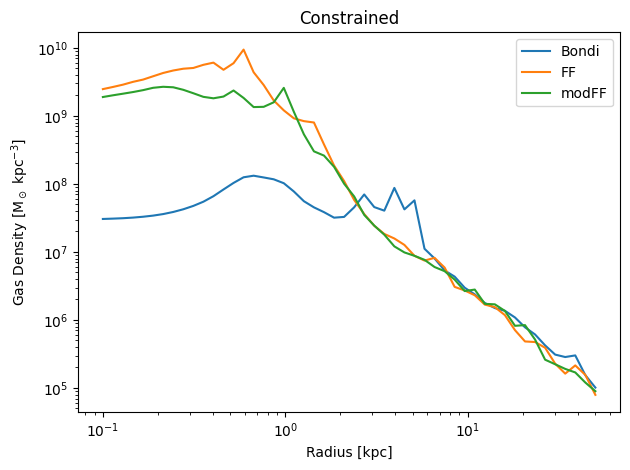

In [36]:
plt.figure()
plt.plot(all_r, Bondi_density,label = 'Bondi')
plt.plot(all_r, FF_density,label = 'FF')
plt.plot(all_r, modFF_density,label = 'modFF')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Radius [kpc]")
plt.ylabel(r"Gas Density [M$_\odot$ kpc$^{-3}$]")
plt.legend()
plt.title('Constrained')
plt.tight_layout()
plt.savefig('Plots/Accretion_gasrho_comparison.png')

# Comparing ICs with same accretion model

In [11]:
# All freefall model, constrained, zoom, and low mass
basePaths = ['/standard/torrey-group/jkho/LtU_Accretion/Freefall/FF_constrained/output/',
            '/project/torrey-group/jkho/LtU_accretion/Zooms/FF_zoom/FF_zoom_contaminated_output/',
            '/standard/torrey-group/jkho/LtU_Accretion/Freefall/FF_low_noAGN/output/',
            '/standard/torrey-group/jkho/LtU_Accretion/Freefall/FF_Rainer/output/']

desired_redshift=15
header = arepo_package.load_snapshot_header(basePaths[0],desired_redshift)
# DMMass = header['MassTable'][1]
z = header['Redshift']
a = 1/(1 + z)
h = 0.6774

Con_mass = []
Con_pos = []
Zoom_mass = []
Zoom_pos = []
Low_mass = []
Low_pos = []
R_mass = []
R_pos = []

for i in range(len(basePaths)):

    basePath = basePaths[i]

    GasMass = get_particle_property_LTU(basePath,'Masses',p_type=0, desired_redshift = desired_redshift)[0] * 1e10/h # Msun
    GasPos = get_particle_property_LTU(basePath,'Coordinates',p_type=0, desired_redshift = desired_redshift)[0] * a/h # kpc
    # GasVel = get_particle_property_LTU(basePath,'Velocities',p_type=0, desired_redshift = desired_redshift)[0] * np.sqrt(a) # km/s
    
    BHMasses,o=arepo_package.get_subhalo_property(basePath,'SubhaloBHMass',desired_redshift)
    target = np.argmax(BHMasses)
    offset = arepo_package.get_subhalo_property(basePath,'SubhaloOffsetType',desired_redshift)[0][target]  # array of 6
    length = arepo_package.get_subhalo_property(basePath,'SubhaloLenType',desired_redshift)[0][target]
    
    GalaxyGasPos = GasPos[offset[0]:offset[0]+length[0]]
    GalaxyGasMass = GasMass[offset[0]:offset[0]+length[0]]
    # GalaxyGasVel = GasVel[offset[0]:offset[0]+length[0]]

    if i == 0:
        Con_mass.append(GalaxyGasMass)
        Con_pos.append(GalaxyGasPos)
    elif i == 1:
        Zoom_mass.append(GalaxyGasMass)
        Zoom_pos.append(GalaxyGasPos)
    elif i == 2:
        Low_mass.append(GalaxyGasMass)
        Low_pos.append(GalaxyGasPos)
    elif i == 3:
        R_mass.append(GalaxyGasMass)
        R_pos.append(GalaxyGasPos * 1e3) # Different units for Rainer param

Desired redshift:  15
Output redshift:  15.035338235804868
Output snapshot:  10
{'BoxSize': 9000.0, 'MassTable': array([0.        , 0.00011289, 0.        , 0.        , 0.        ,
       0.        ]), 'NumFilesPerSnapshot': 16, 'NumPart_ThisFile': array([2920980, 2923686,       0,       0,     440,       0], dtype=uint64), 'NumPart_Total': array([46631878, 46656000,        0,        0,     4463,        6],
      dtype=uint64), 'Redshift': 15.035338235804868, 'Time': 0.06236226422509301}


In [12]:
rmin = 0.1    #the radius at which to start calculating the density
rmax = 50     #the radius at which to stop calculating the density
sphere_samples = 200 #number of measurement samples for each radius
radial_samples = 50  #number of radii to measure density 
DesNgb = 32   #how many particles to use when estimating density

Con_center = np.median(Con_pos[0],axis=0) # Initial guess for the location of the galaxy
Zoom_center = np.median(Zoom_pos[0],axis=0)
Low_center = np.median(Low_pos[0],axis=0)
R_center = np.median(R_pos[0],axis=0)

all_r = np.logspace(np.log10(rmin), np.log10(rmax), radial_samples)
Con_density = []
Zoom_density = []
Low_density = []
R_density = []

for r in all_r:
    points = fibonacci_sphere(sphere_samples, r)
    density = calc_density(Con_pos[0] - Con_center, Con_mass[0], points, DesNgb)
    Con_density.append(density)

    density = calc_density(Zoom_pos[0] - Zoom_center, Zoom_mass[0], points, DesNgb)
    Zoom_density.append(density)

    density = calc_density(Low_pos[0] - Low_center, Low_mass[0], points, DesNgb)
    Low_density.append(density)

    density = calc_density(R_pos[0] - R_center, R_mass[0], points, DesNgb)
    R_density.append(density)

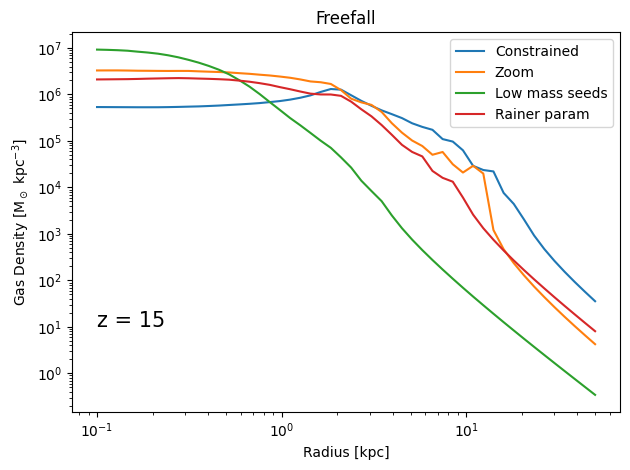

In [13]:
plt.figure()
plt.plot(all_r, Con_density,label = 'Constrained')
plt.plot(all_r, Zoom_density,label = 'Zoom')
plt.plot(all_r, Low_density,label = 'Low mass seeds')
plt.plot(all_r, R_density,label = 'Rainer param')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Radius [kpc]")
plt.ylabel(r"Gas Density [M$_\odot$ kpc$^{-3}$]")
plt.legend()
plt.title('Freefall')
plt.text(1e-1,1e1,f'z = {desired_redshift}',fontsize=15)
plt.tight_layout()
plt.savefig(f'Plots/Accretion_gasrho_comparison_FF_z{desired_redshift}.png')

# Most massive halo history

In [8]:
# All freefall model, constrained, zoom, and low mass
basePaths = ['/standard/torrey-group/jkho/LtU_Accretion/Constrained/FF_constrained/output/',
            '/standard/torrey-group/jkho/LtU_Accretion/Zoom/FF_zoom_AGN/output/',
            '/standard/torrey-group/jkho/LtU_Accretion/Small_Uniform/FF_low_noAGN/output/',
            '/standard/torrey-group/jkho/LtU_Accretion/Rainer/FF_Rainer/output/']

desired_redshifts=np.arange(20,6,-1)
h = 0.6774

Con_Mass = []
Zoom_Mass = []
Low_Mass = []
R_Mass = []

for i in range(len(desired_redshifts)):
    
    for ii in range(len(basePaths)):

        basePath = basePaths[ii]
        GroupMasses =arepo_package.get_group_property(basePath,'GroupMass',desired_redshifts[i])[0] * 1e10/h
        target = np.argmax(GroupMasses)
    
        if ii == 0:
            Con_Mass.append(GroupMasses[target])
        elif ii == 1:
            Zoom_Mass.append(GroupMasses[target])
        elif ii == 2:
            Low_Mass.append(GroupMasses[target])
        elif ii == 3:
            R_Mass.append(GroupMasses[target])


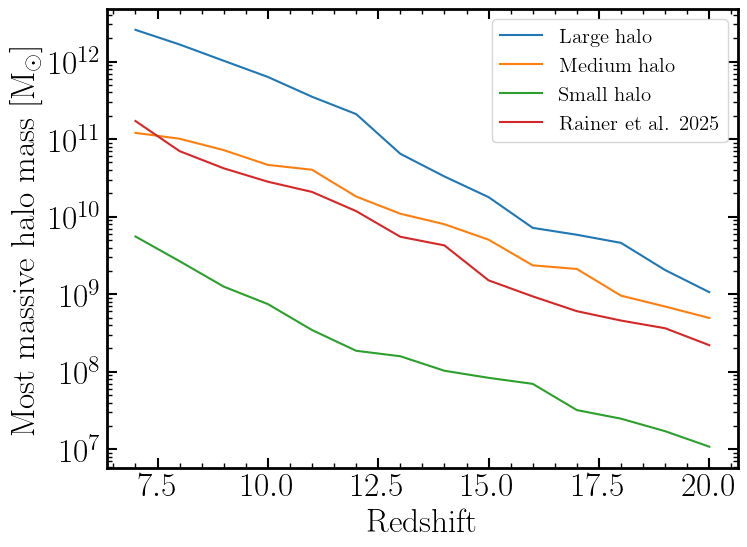

In [16]:
plt.figure(figsize=(8,6))
plt.plot(desired_redshifts, Con_Mass,label = 'Large halo')
plt.plot(desired_redshifts, Zoom_Mass,label = 'Medium halo')
plt.plot(desired_redshifts, Low_Mass,label = 'Small halo')
plt.plot(desired_redshifts, R_Mass,label = 'Rainer et al. 2025')
# plt.xscale("log")
plt.yscale("log")
plt.xlabel("Redshift")
plt.ylabel(r"Most massive halo mass [M$_\odot$]")
plt.legend(fontsize=15)
# plt.title('Freefall')
# plt.text(1e-1,1e1,f'z = {desired_redshift}',fontsize=15)
plt.tight_layout()
plt.savefig(f'Plots/Halomass_comparison.png')

# Comparing density profiles for feedback vs. no feedback cases

In [40]:
Filepath = '/project/torrey-group/jkho/LtU_accretion' 
Box = 'Zooms' # 'Constrained' # 'Low_mass_seeds' # 
SimPaths = [['Bondi_zoom_boost','FF_zoom','modFF_zoom'],['Bondi_zoom_AGN','FF_zoom_AGN','modFF_zoom_AGN']] 
outputpath = 'output'

desired_redshift=6
header = arepo_package.load_snapshot_header(f'{Filepath}/{Box}/{Simpaths[0][0]}/{outputpath}',desired_redshift)
DMMass = header['MassTable'][1]
z = header['Redshift']
a = 1/(1 + z)
h = 0.6774

Bondi_mass = []
Bondi_pos = []
FF_mass = []
FF_pos = []
modFF_mass = []
modFF_pos = []

for ii in range(len(SimPaths)):

    Bondi_mass_i = []
    Bondi_pos_i = []
    FF_mass_i = []
    FF_pos_i = []
    modFF_mass_i = []
    modFF_pos_i = []

    for sim in SimPaths[ii]:

        basePath = f'{Filepath}/{Box}/{sim}/{outputpath}/'
    
        GasMass = get_particle_property_LTU(basePath,'Masses',p_type=0, desired_redshift = desired_redshift)[0] * 1e10/h # Msun
        GasPos = get_particle_property_LTU(basePath,'Coordinates',p_type=0, desired_redshift = desired_redshift)[0] * a/h # kpc
        # GasVel = get_particle_property_LTU(basePath,'Velocities',p_type=0, desired_redshift = desired_redshift)[0] * np.sqrt(a) # km/s
        
        BHMasses,o=arepo_package.get_subhalo_property(basePath,'SubhaloBHMass',desired_redshift)
        target = np.argmax(BHMasses)
        offset = arepo_package.get_subhalo_property(basePath,'SubhaloOffsetType',desired_redshift)[0][target]  # array of 6
        length = arepo_package.get_subhalo_property(basePath,'SubhaloLenType',desired_redshift)[0][target]
        
        GalaxyGasPos = GasPos[offset[0]:offset[0]+length[0]]
        GalaxyGasMass = GasMass[offset[0]:offset[0]+length[0]]
        # GalaxyGasVel = GasVel[offset[0]:offset[0]+length[0]]
    
        if sim == SimPaths[ii][0]:
            Bondi_mass_i.append(GalaxyGasMass)
            Bondi_pos_i.append(GalaxyGasPos)
        elif sim == SimPaths[ii][1]:
            FF_mass_i.append(GalaxyGasMass)
            FF_pos_i.append(GalaxyGasPos)
        elif sim == SimPaths[ii][2]:
            modFF_mass_i.append(GalaxyGasMass)
            modFF_pos_i.append(GalaxyGasPos)

    Bondi_mass.append(Bondi_mass_i)
    Bondi_pos.append(Bondi_pos_i)
    FF_mass.append(FF_mass_i)
    FF_pos.append(FF_pos_i)
    modFF_mass.append(modFF_mass_i)
    modFF_pos.append(modFF_pos_i)

Desired redshift:  6
Output redshift:  6.0107573988449
Output snapshot:  19
{'BoxSize': np.float64(25000.0), 'MassTable': array([0.00000000e+00, 1.31400861e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00]), 'NumFilesPerSnapshot': np.int32(16), 'NumPart_ThisFile': array([2276075, 1954826,  347382,       0,   57580,       0], dtype=uint64), 'NumPart_Total': array([36399729, 33212696,  4195263,        0,   670370,       15],
      dtype=uint64), 'Redshift': np.float64(6.0107573988449), 'Time': np.float64(0.1426379409683697)}
Current snapshot:  19
Current snapshot:  19
Current snapshot:  19
Current snapshot:  19
Current snapshot:  19
Current snapshot:  19
Current snapshot:  19
Current snapshot:  19
Current snapshot:  19
Current snapshot:  19
Current snapshot:  19
Current snapshot:  19


In [41]:
rmin = 0.1    #the radius at which to start calculating the density
rmax = 50     #the radius at which to stop calculating the density
sphere_samples = 200 #number of measurement samples for each radius
radial_samples = 50  #number of radii to measure density 
DesNgb = 32   #how many particles to use when estimating density

Bondi_center_noAGN = np.median(Bondi_pos[0][0],axis=0) # Initial guess for the location of the dwarf galaxy
FF_center_noAGN = np.median(FF_pos[0][0],axis=0)
modFF_center_noAGN = np.median(modFF_pos[0][0],axis=0)

Bondi_center_AGN = np.median(Bondi_pos[1][0],axis=0) # Initial guess for the location of the dwarf galaxy
FF_center_AGN = np.median(FF_pos[1][0],axis=0)
modFF_center_AGN = np.median(modFF_pos[1][0],axis=0)

all_r = np.logspace(np.log10(rmin), np.log10(rmax), radial_samples)

Bondi_density_noAGN = []
FF_density_noAGN = []
modFF_density_noAGN = []

Bondi_density_AGN = []
FF_density_AGN = []
modFF_density_AGN = []

for r in all_r:
    points = fibonacci_sphere(sphere_samples, r)
    
    density = calc_density(Bondi_pos[0][0] - Bondi_center_noAGN, Bondi_mass[0][0], points, DesNgb)
    Bondi_density_noAGN.append(density)

    density = calc_density(FF_pos[0][0] - FF_center_noAGN, FF_mass[0][0], points, DesNgb)
    FF_density_noAGN.append(density)

    density = calc_density(modFF_pos[0][0] - modFF_center_noAGN, modFF_mass[0][0], points, DesNgb)
    modFF_density_noAGN.append(density)
    

    density = calc_density(Bondi_pos[1][0] - Bondi_center_AGN, Bondi_mass[1][0], points, DesNgb)
    Bondi_density_AGN.append(density)

    density = calc_density(FF_pos[1][0] - FF_center_AGN, FF_mass[1][0], points, DesNgb)
    FF_density_AGN.append(density)

    density = calc_density(modFF_pos[1][0] - modFF_center_AGN, modFF_mass[1][0], points, DesNgb)
    modFF_density_AGN.append(density)

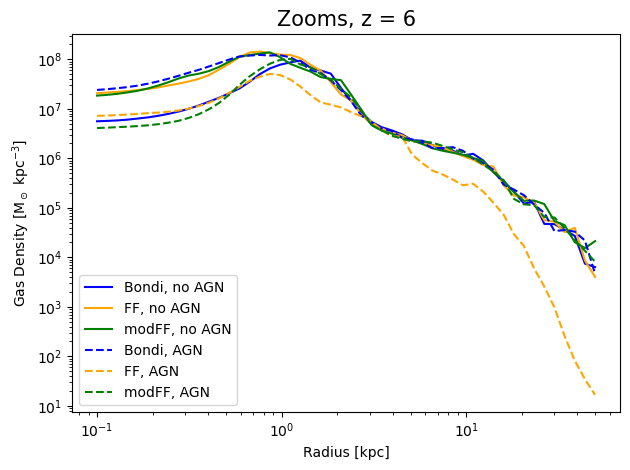

In [42]:
plt.figure()
plt.plot(all_r, Bondi_density_noAGN,label = 'Bondi, no AGN',color='blue')
plt.plot(all_r, FF_density_noAGN,label = 'FF, no AGN',color='orange')
plt.plot(all_r, modFF_density_noAGN,label = 'modFF, no AGN',color='green')

plt.plot(all_r, Bondi_density_AGN,label = 'Bondi, AGN',color='blue',ls = '--')
plt.plot(all_r, FF_density_AGN,label = 'FF, AGN',color='orange',ls = '--')
plt.plot(all_r, modFF_density_AGN,label = 'modFF, AGN',color='green',ls = '--')

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Radius [kpc]")
plt.ylabel(r"Gas Density [M$_\odot$ kpc$^{-3}$]")
plt.legend()
plt.title(f'{Box}, z = {desired_redshift}',size=15)
# plt.ylim(1e2,1e9)

plt.tight_layout()
plt.savefig(f'Plots/{Box}_AGN_Accretion_gasrho_comparison_z{desired_redshift}.png')

# Average profiles from above:

In [ ]:
Filepath = '/project/torrey-group/jkho/LtU_accretion' 
Box = 'Zooms' # 'Constrained' # 'Low_mass_seeds' # 
SimPaths = [['Bondi_zoom_boost','FF_zoom','modFF_zoom'],['Bondi_zoom_AGN','FF_zoom_AGN','modFF_zoom_AGN']] 
outputpath = 'output'

desired_redshifts=np.arange(12,5,-1)
header = arepo_package.load_snapshot_header(f'{Filepath}/{Box}/{SimPaths[0][0]}/{outputpath}',desired_redshifts[0])
DMMass = header['MassTable'][1]
a = 1/(1 + desired_redshifts)
h = 0.6774

Bondi_mass_noAGN = []
Bondi_pos_noAGN = []
FF_mass_noAGN = []
FF_pos_noAGN = []
modFF_mass_noAGN = []
modFF_pos_noAGN = []

Bondi_mass_AGN = []
Bondi_pos_AGN = []
FF_mass_AGN = []
FF_pos_AGN = []
modFF_mass_AGN = []
modFF_pos_AGN = []

for ii in range(len(SimPaths)):

    Bondi_mass_i_noAGN = []
    Bondi_pos_i_noAGN = []
    FF_mass_i_noAGN = []
    FF_pos_i_noAGN = []
    modFF_mass_i_noAGN = []
    modFF_pos_i_noAGN = []

    Bondi_mass_i_AGN = []
    Bondi_pos_i_AGN = []
    FF_mass_i_AGN = []
    FF_pos_i_AGN = []
    modFF_mass_i_AGN = []
    modFF_pos_i_AGN = []

    for sim in SimPaths[ii]:
        
        basePath = f'{Filepath}/{Box}/{sim}/{outputpath}/'

        for iii in range(len(desired_redshifts)):
        
            GasMass = get_particle_property_LTU(basePath,'Masses',p_type=0, desired_redshift = desired_redshifts[iii])[0] * 1e10/h # Msun
            GasPos = get_particle_property_LTU(basePath,'Coordinates',p_type=0, desired_redshift = desired_redshifts[iii])[0] * a[iii]/h # kpc
            # GasVel = get_particle_property_LTU(basePath,'Velocities',p_type=0, desired_redshift = desired_redshift)[0] * np.sqrt(a) # km/s
            
            BHMasses,o=arepo_package.get_subhalo_property(basePath,'SubhaloBHMass',desired_redshifts[iii])
            target = np.argmax(BHMasses)
            offset = arepo_package.get_subhalo_property(basePath,'SubhaloOffsetType',desired_redshifts[iii])[0][target]  # array of 6
            length = arepo_package.get_subhalo_property(basePath,'SubhaloLenType',desired_redshifts[iii])[0][target]
            
            GalaxyGasPos = GasPos[offset[0]:offset[0]+length[0]]
            GalaxyGasMass = GasMass[offset[0]:offset[0]+length[0]]
            # GalaxyGasVel = GasVel[offset[0]:offset[0]+length[0]]

            if ii == 0:
                if sim == SimPaths[ii][0]:
                    Bondi_mass_i_noAGN.append(GalaxyGasMass)
                    Bondi_pos_i_noAGN.append(GalaxyGasPos)
                elif sim == SimPaths[ii][1]:
                    FF_mass_i_noAGN.append(GalaxyGasMass)
                    FF_pos_i_noAGN.append(GalaxyGasPos)
                elif sim == SimPaths[ii][2]:
                    modFF_mass_i_noAGN.append(GalaxyGasMass)
                    modFF_pos_i_noAGN.append(GalaxyGasPos)
            elif ii == 1:
                if sim == SimPaths[ii][0]:
                    Bondi_mass_i_AGN.append(GalaxyGasMass)
                    Bondi_pos_i_AGN.append(GalaxyGasPos)
                elif sim == SimPaths[ii][1]:
                    FF_mass_i_AGN.append(GalaxyGasMass)
                    FF_pos_i_AGN.append(GalaxyGasPos)
                elif sim == SimPaths[ii][2]:
                    modFF_mass_i_AGN.append(GalaxyGasMass)
                    modFF_pos_i_AGN.append(GalaxyGasPos)
                

    Bondi_mass_noAGN.append(Bondi_mass_i_noAGN)
    Bondi_pos_noAGN.append(Bondi_pos_i_noAGN)
    FF_mass_noAGN.append(FF_mass_i_noAGN)
    FF_pos_noAGN.append(FF_pos_i_noAGN)
    modFF_mass_noAGN.append(modFF_mass_i_noAGN)
    modFF_pos_noAGN.append(modFF_pos_i_noAGN)

    Bondi_mass_AGN.append(Bondi_mass_i_AGN)
    Bondi_pos_AGN.append(Bondi_pos_i_AGN)
    FF_mass_AGN.append(FF_mass_i_AGN)
    FF_pos_AGN.append(FF_pos_i_AGN)
    modFF_mass_AGN.append(modFF_mass_i_AGN)
    modFF_pos_AGN.append(modFF_pos_i_AGN)

Desired redshift:  12
Output redshift:  11.980213315300293
Output snapshot:  13
{'BoxSize': np.float64(25000.0), 'MassTable': array([0.00000000e+00, 1.31400861e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00]), 'NumFilesPerSnapshot': np.int32(16), 'NumPart_ThisFile': array([2310014, 2081265,  257667,       0,    1999,       0], dtype=uint64), 'NumPart_Total': array([37076935, 33212696,  4195263,        0,    23507,        7],
      dtype=uint64), 'Redshift': np.float64(11.980213315300293), 'Time': np.float64(0.07704033637268967)}
Current snapshot:  13
Current snapshot:  13
Current snapshot:  14
Current snapshot:  14
Current snapshot:  15
Current snapshot:  15
Current snapshot:  16
Current snapshot:  16
Current snapshot:  17
Current snapshot:  17
Current snapshot:  18
Current snapshot:  18
Current snapshot:  19
Current snapshot:  19
Current snapshot:  13
Current snapshot:  13
Current snapshot:  14
Current snapshot:  14
Current snapshot:  15
Current snapshot:  

In [ ]:
rmin = 0.1    #the radius at which to start calculating the density
rmax = 50     #the radius at which to stop calculating the density
sphere_samples = 200 #number of measurement samples for each radius
radial_samples = 50  #number of radii to measure density 
DesNgb = 32   #how many particles to use when estimating density

Bondi_density_noAGN = []
FF_density_noAGN = []
modFF_density_noAGN = []

Bondi_density_AGN = []
FF_density_AGN = []
modFF_density_AGN = []


Bondi_center_noAGN = np.median(Bondi_pos[0][0],axis=0) # Initial guess for the location of the dwarf galaxy
FF_center_noAGN = np.median(FF_pos[0][0],axis=0)
modFF_center_noAGN = np.median(modFF_pos[0][0],axis=0)

Bondi_center_AGN = np.median(Bondi_pos[1][0],axis=0) # Initial guess for the location of the dwarf galaxy
FF_center_AGN = np.median(FF_pos[1][0],axis=0)
modFF_center_AGN = np.median(modFF_pos[1][0],axis=0)

all_r = np.logspace(np.log10(rmin), np.log10(rmax), radial_samples)

for r in all_r:
    points = fibonacci_sphere(sphere_samples, r)
    
    density = calc_density(Bondi_pos[0][0] - Bondi_center_noAGN, Bondi_mass[0][0], points, DesNgb)
    Bondi_density_noAGN.append(density)

    density = calc_density(FF_pos[0][0] - FF_center_noAGN, FF_mass[0][0], points, DesNgb)
    FF_density_noAGN.append(density)

    density = calc_density(modFF_pos[0][0] - modFF_center_noAGN, modFF_mass[0][0], points, DesNgb)
    modFF_density_noAGN.append(density)
    

    density = calc_density(Bondi_pos[1][0] - Bondi_center_AGN, Bondi_mass[1][0], points, DesNgb)
    Bondi_density_AGN.append(density)

    density = calc_density(FF_pos[1][0] - FF_center_AGN, FF_mass[1][0], points, DesNgb)
    FF_density_AGN.append(density)

    density = calc_density(modFF_pos[1][0] - modFF_center_AGN, modFF_mass[1][0], points, DesNgb)
    modFF_density_AGN.append(density)

In [ ]:
plt.figure()
plt.plot(all_r, Bondi_density_noAGN,label = 'Bondi, no AGN',color='blue')
plt.plot(all_r, FF_density_noAGN,label = 'FF, no AGN',color='orange')
plt.plot(all_r, modFF_density_noAGN,label = 'modFF, no AGN',color='green')

plt.plot(all_r, Bondi_density_AGN,label = 'Bondi, AGN',color='blue',ls = '--')
plt.plot(all_r, FF_density_AGN,label = 'FF, AGN',color='orange',ls = '--')
plt.plot(all_r, modFF_density_AGN,label = 'modFF, AGN',color='green',ls = '--')

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Radius [kpc]")
plt.ylabel(r"Gas Density [M$_\odot$ kpc$^{-3}$]")
plt.legend()
plt.title(f'{Box}, z = {desired_redshift}',size=15)
# plt.ylim(1e2,1e9)

plt.tight_layout()
plt.savefig(f'Plots/{Box}_AGN_Accretion_gasrho_comparison_z{desired_redshift}.png')

# Halo masses of seeding events

In [4]:
Constrained = '/project/torrey-group/jkho/LtU_accretion/Constrained/Bondi_constrained_AGN_stellar_lenient/output/'
Zoom = '/project/torrey-group/jkho/LtU_accretion/Zooms/Bondi_zoom_AGN_stellar_lenient/output/'
Small = '/project/torrey-group/jkho/LtU_accretion/Low_mass_seeds/Bondi_lowmass_AGN_stellar_lenient/output/'

seeding_constrained = arepo_package.get_seeding_events(Constrained)
seeding_zoom = arepo_package.get_seeding_events(Zoom)
seeding_small = arepo_package.get_seeding_events(Small)

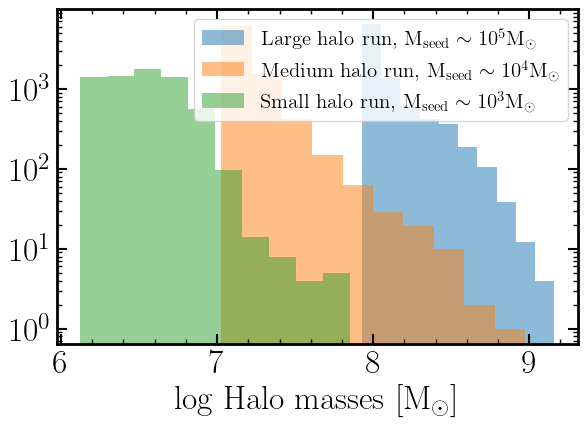

In [5]:
plt.hist(np.log10(seeding_constrained[5]*1e10),label = r'Large halo run, $\rm M_{seed}\sim 10^5 M_\odot$',alpha=0.5,log=True)
plt.hist(np.log10(seeding_zoom[5]*1e10),label = r'Medium halo run, $\rm M_{seed}\sim 10^4 M_\odot$',alpha=0.5,log=True)
plt.hist(np.log10(seeding_small[5]*1e10),label = r'Small halo run, $\rm M_{seed}\sim 10^3 M_\odot$',alpha=0.5,log=True)

# plt.xscale('log')
plt.legend(fontsize=15)
plt.xlabel(r'log Halo masses $\rm [M_\odot]$')
plt.tight_layout()
plt.savefig('Plots/Seeding_halo_masses_log.png')